![This is an image](Quant-Trading.jpg)

<font size="3">
Please visit our website <a href="https://www.quant-trading.co" target="_blank">quant-trading.co</a> for more tools on quantitative finance and data science.
</font>

# **HOW TO CALCULATE IMPLIED DENSITY FUNCTION FROM OPTIONS PRICES**

## **¿What is the implied density function?**

<font size="3"> In this post we are going to explain the implied density function that is obtained from option prices. This means that you can calculate for instance, the probability that the spot price finishes above or below a particular threshold or within some price limit. It is important to note that this probability distribution is in a risk neutral world that differs from the world we are trading. Nevertheless, for options that not expire very far in the future, differences might be negligible<br><br>

<font size="3"> Options markets have come a long way since the 1970s, when the <a href="https://quant-trading.co/black-scholes-formula-in-python/" target="_blank">Black Scholes (BS) formula</a> was published. The formula became so well established in traders' minds that it is still widely used today despite its flaws. One of the biggest consequences from the used of this formula was the concept of implied volatility as we explain <a href="https://quant-trading.co/how-to-calculate-implied-volatility-from-options-prices/" target="_blank">here</a>. We can calculate not only implied volatilities but also an implied density function.<br><br>
    
<font size="3"> To do that, we need to get the second derivative of the option's price with respect to the strike price. We also need to have a particular function for the volatility in relation with the strikes. Doing a little algebra and some calculation we arrived to the implied density function. Those of you who would like to see step by step guide on how to do it, please look, here. <br><br>

## **Import the required libraries**

<font size="3"> We will need to use the pandas and numpy library as well as others like yahoo finance or scipy. The latter is to fitt the market implied volatility with the theoretical functional form we are using. For the plots we will also need the matplotlib.pyplot <br><br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import datetime
from matplotlib.ticker import FormatStrFormatter
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import minimize

## **Define a functional form for the volatility**

<font size="3"> We need to define a functional form for the volatility. One of the simplest and most versatiles in the parabolic skew as was explained in this document. To implement this in python you can follow the script below.<br><br>

In [2]:
def bsparabolicprob( S0, x, r, tenor,sigma0, sigma1, sigma2, q=0., t=0.):

    RN_prob = np.array([0.0])
    y = np.asarray(x)

    if y.size == 1:

        #Changing possible integers to float
        S0 = float(S0)
        x = float(x)
        r = float(r)
        tenor = float(tenor)
        sigma0 = float(sigma0)
        sigma1 = float(sigma1)
        sigma2 = float(sigma2)
        

        #Skew function
        sigma = sigma0 + sigma1*np.log(y/S0)+sigma2*(np.log(y/S0))**2

        #First derivative of the skew function with respect to strike
        sigma_prime = (sigma1/y) + (2*sigma2/y)*np.log(y/S0)

        #Second derivative of the skew function with respect to strike
        sigma_primeprime = (1/y**2)*(-sigma1 +2*sigma2- 2*sigma2*np.log(y/S0))    

        T = tenor - t
        d1 = (np.log(S0 / y) + (r  + sigma**2 / 2) * T) / (sigma * T**0.5)
        d2 = d1 - sigma * T**0.5

        
        #we need to calculate different derivatives to express the second total derivative of the price with respect to the strike. 

        #Vega
        vega =  S0*(T**0.5)*norm.pdf(d1)

        #Partial second derivative of the price with respect to the vol
        D2CDVOL2 = (vega*d1*d2)/sigma

        #Partial second derivative of the price with respect to the strike
        D2CDK2 = (np.exp(-r*tenor)*norm.pdf(d2))/(y*sigma*tenor**0.5)

        #Partial cross second derivative of the price with respect to the strike and the vol
        D2CDKDVOL = (np.exp(-r*tenor)*norm.pdf(d2)*d1)/sigma

        #Total second derivative of the price with respect to strike
        TOTAL = D2CDVOL2*(sigma_prime**2)+2*D2CDKDVOL*sigma_prime+vega*sigma_primeprime+D2CDK2
        
        #Risk neutral prob measure           
        RN_prob = np.exp(r*tenor)*TOTAL
    
        return RN_prob

    else:

        #Changing possible integers to float
        S0 = float(S0)
        x = x.astype(float)
        r = float(r)
        tenor = float(tenor)
        sigma0 = float(sigma0)
        sigma1 = float(sigma1)
        sigma2 = float(sigma2)
           
        for i in range(0,y.size):
        
            #Skew function
            sigma = sigma0 + sigma1*np.log(x[i]/S0)+sigma2*(np.log(x[i]/S0))**2

            #First derivative of the skew function with respect to strike
            sigma_prime = (sigma1/x[i]) + (2*sigma2/x[i])*np.log(x[i]/S0)

            #Second derivative of the skew function with respect to strike
            sigma_primeprime = (1/x[i]**2)*(-sigma1 +2*sigma2- 2*sigma2*np.log(x[i]/S0))    

            T = tenor - t
            d1 = (np.log(S0 / x[i]) + (r  + sigma**2 / 2) * T) / (sigma * T**0.5)
            d2 = d1 - sigma * T**0.5

            
            #we need to calculate different derivatives to express the second total derivative of the price with respect to the strike. 

            #Vega
            vega =  S0*(T**0.5)*norm.pdf(d1)

            #Partial second derivative of the price with respect to the vol
            D2CDVOL2 = (vega*d1*d2)/sigma

            #Partial second derivative of the price with respect to the strike
            D2CDK2 = (np.exp(-r*tenor)*norm.pdf(d2))/(x[i]*sigma*tenor**0.5)

            #Partial cross second derivative of the price with respect to the strike and the vol
            D2CDKDVOL = (np.exp(-r*tenor)*norm.pdf(d2)*d1)/sigma

            #Total second derivative of the price with respect to strike
            TOTAL = D2CDVOL2*(sigma_prime**2)+2*D2CDKDVOL*sigma_prime+vega*sigma_primeprime+D2CDK2
            
            #Risk neutral prob measure   
            RN_prob.resize(y.size)
            RN_prob[i] = np.exp(r*tenor)*TOTAL
        
        return RN_prob

## **Download the data for options prices**

<font size="3"> We can use the yahoo finance API to download that information. We explain in great detail how to use the API <a href="https://quant-trading.co/how-to-download-data-from-yahoo-finance-api/" target="_blank"> here</a>.  To get the options expirations you need to write the script below. Please remember that we need all this information to be able to calculate the implied density function from those options prices.<br><br>

In [3]:
#ASSET
ticker = 'SPY'
my_ticker = yf.Ticker(ticker)

#Options expiration dates
exp_dates = my_ticker.options
exp_dates

('2025-01-21',
 '2025-01-22',
 '2025-01-23',
 '2025-01-24',
 '2025-01-31',
 '2025-02-07',
 '2025-02-14',
 '2025-02-21',
 '2025-02-28',
 '2025-03-21',
 '2025-03-31',
 '2025-04-17',
 '2025-04-30',
 '2025-05-16',
 '2025-05-30',
 '2025-06-20',
 '2025-06-30',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-09-30',
 '2025-12-19',
 '2025-12-31',
 '2026-01-16',
 '2026-03-20',
 '2026-06-18',
 '2026-12-18',
 '2027-01-15',
 '2027-12-17')

## **Download the option's chain**

<font size="3"> When we know a specific date from the previous script, we can search for the set of options that are dealt using the following script. Please take in mind that this blog post was written in 2025, so you need to adjust the date to get updated information.<br><br>

In [4]:
my_options = my_ticker.option_chain('2025-04-17')[0]
my_options.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY250417C00260000,2025-01-14 14:43:40+00:00,260.0,327.50,338.31,341.53,0.0,0.0,2.0,4,0.916383,True,REGULAR,USD
1,SPY250417C00270000,2024-12-04 19:19:14+00:00,270.0,339.72,323.01,326.64,0.0,0.0,2.0,3,0.000010,True,REGULAR,USD
2,SPY250417C00275000,2024-11-06 14:35:00+00:00,275.0,316.00,334.22,337.87,0.0,0.0,1.0,1,1.282291,True,REGULAR,USD
3,SPY250417C00280000,2024-09-19 13:47:05+00:00,280.0,293.02,308.53,311.42,0.0,0.0,3.0,0,0.000010,True,REGULAR,USD
4,SPY250417C00285000,2024-11-14 20:47:18+00:00,285.0,312.80,320.65,323.87,0.0,0.0,1.0,1,1.124943,True,REGULAR,USD


In [5]:
my_options.tail()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
107,SPY250417C00810000,2025-01-13 16:51:14+00:00,810.0,0.01,0.01,0.02,0.00,0.0,10.0,258,0.199227,False,REGULAR,USD
108,SPY250417C00815000,2025-01-13 17:20:12+00:00,815.0,0.01,0.01,0.02,0.00,0.0,4.0,241,0.203133,False,REGULAR,USD
109,SPY250417C00820000,2025-01-16 20:09:37+00:00,820.0,0.01,0.01,0.02,0.00,0.0,3.0,160,0.207039,False,REGULAR,USD
110,SPY250417C00825000,2025-01-14 19:19:36+00:00,825.0,0.01,0.01,0.02,0.00,0.0,10.0,1321,0.209969,False,REGULAR,USD
111,SPY250417C00830000,2025-01-17 16:47:11+00:00,830.0,0.02,0.01,0.02,0.01,100.0,9.0,1626,0.212898,False,REGULAR,USD


## **Filter the DataFrame**

<font size="3"> We don't want to have options that are very far out of the money. The reason is that implied volatilities for those might be a little distorted since demand and supply is low. Additionally, if you don't take into account specific details for the implied volatility calculations you can get not very accurate numbers. In this case we are going to filter those rows between the 25 and 106.<br><br>

In [6]:
my_options_filtered = my_options.iloc[25:106]
my_options_filtered

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
25,SPY250417C00400000,2025-01-17 20:32:05+00:00,400.0,202.38,200.05,203.30,21.40001,11.824516,1.0,188,0.547673,True,REGULAR,USD
26,SPY250417C00405000,2025-01-02 14:30:02+00:00,405.0,189.76,195.14,198.39,0.00000,0.000000,699.0,200,0.536504,True,REGULAR,USD
27,SPY250417C00410000,2025-01-15 17:17:50+00:00,410.0,185.75,190.23,193.48,0.00000,0.000000,2.0,164,0.525334,True,REGULAR,USD
28,SPY250417C00415000,2024-12-20 19:00:23+00:00,415.0,184.67,185.32,188.57,0.00000,0.000000,2.0,108,0.514165,True,REGULAR,USD
29,SPY250417C00420000,2024-12-20 16:23:03+00:00,420.0,179.72,180.41,183.66,0.00000,0.000000,4.0,675,0.502996,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,SPY250417C00780000,2025-01-15 19:53:25+00:00,780.0,0.02,0.02,0.03,0.00000,0.000000,400.0,892,0.182625,False,REGULAR,USD
102,SPY250417C00785000,2025-01-03 16:42:21+00:00,785.0,0.04,0.02,0.03,0.00000,0.000000,817.0,752,0.186532,False,REGULAR,USD
103,SPY250417C00790000,2025-01-17 18:00:28+00:00,790.0,0.02,0.02,0.03,0.00000,0.000000,400.0,532,0.190438,False,REGULAR,USD
104,SPY250417C00795000,2025-01-16 14:57:59+00:00,795.0,0.01,0.01,0.02,0.00000,0.000000,1.0,141,0.187508,False,REGULAR,USD


## **Get a list for the strikes and implied volatilities**

<font size="3"> We put the strike prices into a list as follows: <br><br>

In [7]:
my_options_filtered_strikes = list(my_options_filtered['strike'])
my_options_filtered_strikes

[400.0,
 405.0,
 410.0,
 415.0,
 420.0,
 425.0,
 430.0,
 435.0,
 440.0,
 445.0,
 450.0,
 455.0,
 460.0,
 465.0,
 470.0,
 475.0,
 480.0,
 485.0,
 490.0,
 495.0,
 500.0,
 505.0,
 510.0,
 515.0,
 520.0,
 525.0,
 530.0,
 535.0,
 540.0,
 545.0,
 550.0,
 555.0,
 560.0,
 565.0,
 570.0,
 575.0,
 580.0,
 585.0,
 590.0,
 595.0,
 600.0,
 605.0,
 610.0,
 615.0,
 620.0,
 625.0,
 630.0,
 635.0,
 640.0,
 645.0,
 650.0,
 655.0,
 660.0,
 665.0,
 670.0,
 675.0,
 680.0,
 685.0,
 690.0,
 695.0,
 700.0,
 705.0,
 710.0,
 715.0,
 720.0,
 725.0,
 730.0,
 735.0,
 740.0,
 745.0,
 750.0,
 755.0,
 760.0,
 765.0,
 770.0,
 775.0,
 780.0,
 785.0,
 790.0,
 795.0,
 800.0]

<font size="3"> And repeat the procedure for implied volatilities<br><br>

In [8]:
my_options_filtered_vols = list(my_options_filtered['impliedVolatility'])
my_options_filtered_vols

[0.5476729803466798,
 0.5365036584472658,
 0.5253343365478516,
 0.5141650146484374,
 0.5029956927490236,
 0.5321702056884765,
 0.5201769174194336,
 0.5081836291503907,
 0.49622085815429695,
 0.4844411907958984,
 0.47269204071044923,
 0.46094289062500005,
 0.4493463269042969,
 0.43774976318359377,
 0.42627526855468756,
 0.41498387756347654,
 0.4037840383911133,
 0.39267575103759766,
 0.3816590155029296,
 0.37070331451416016,
 0.359808648071289,
 0.34906656799316405,
 0.33847707427978513,
 0.3279943910217285,
 0.31757274230957033,
 0.307349455871582,
 0.2970956521606445,
 0.28707072799682615,
 0.27719839019775383,
 0.2674023455810547,
 0.25763681823730467,
 0.2481612049865723,
 0.2210923838806152,
 0.21253228881835937,
 0.20429262512207028,
 0.1957935646057129,
 0.1876454527282715,
 0.17815458084106445,
 0.1703726762390137,
 0.1628806857299805,
 0.15581593704223634,
 0.14902584381103517,
 0.1427545442199707,
 0.13707833145141607,
 0.132119274597168,
 0.1279231495666504,
 0.12452047363281

<font size="3"> And here you can see how we can acces a particular strike in the list.<br><br>

In [9]:
my_options_filtered_strikes[0]

400.0

## **Calculate the barabolic skew volatilities**

<font size="3"> We can assign specific values to the parameters that are required to calculate the parabolic skew volatilities and the proceed to calculate them. To do that we will iterate using a for loop as follows:<br><br>

In [10]:
S0 = 590
sigma0 = 0.19
sigma1 = 0.21
sigma2 = 1.4

sigma_vector = []

for i in range (0, len(my_options_filtered_vols)):
    sigma = sigma0 + sigma1*np.log(my_options_filtered_strikes[i]/S0)+sigma2*(np.log(my_options_filtered_strikes[i]/S0))**2
    sigma_vector.append(sigma)

sigma_vector

[0.3198588683843113,
 0.30916493156616387,
 0.2990263849096157,
 0.2894246533916476,
 0.28034195106987714,
 0.2717612394325272,
 0.2636661883840154,
 0.2560411396718496,
 0.24887107257684687,
 0.24214157170347808,
 0.23583879672056293,
 0.22994945391471053,
 0.22446076942997484,
 0.2193604640772599,
 0.2146367296061858,
 0.2102782063404849,
 0.2062739620856303,
 0.20261347222437054,
 0.19928660092221656,
 0.19628358337076401,
 0.19359500900207458,
 0.19121180561224346,
 0.18912522433677428,
 0.18732682542451473,
 0.1858084647607015,
 0.18456228109315745,
 0.1835806839188987,
 0.18285634199137427,
 0.18238217241129315,
 0.18215133026651642,
 0.18215719878882236,
 0.18239337999750385,
 0.18285368580175182,
 0.18353212953561945,
 0.18442291790107082,
 0.18552044329619974,
 0.18681927650717275,
 0.18831415974381202,
 0.19,
 0.1918718627212626,
 0.1939249657629812,
 0.1961546736237018,
 0.19855649193895475,
 0.20112606222188414,
 0.20385915683780345,
 0.20675167420056653,
 0.209799634179353

## **Minimize the differences to get the optimal parameters**

<font size="3"> We define a new function that calculates the differences between market implied volatilities and the ones that we just obtained from arbitrary parameters. We then minimize those differences to get the optimal parameters. In our <a href="https://quant-trading.co/cursos/trading-algoritmico-2/" target="_blank">Algorithmic Trading Course</a> we explain these optimization methods in greater detail. <br><br>

In [11]:
def parabolic_skew_differences(parameters):
    
    S0 = 590
    sigma0 = parameters[0]
    sigma1 = parameters[1]
    sigma2 = parameters[2]

    sigma_vector = []

    for i in range (0, len(my_options_filtered_vols)):
        sigma = sigma0 + sigma1*np.log(my_options_filtered_strikes[i]/S0)+sigma2*(np.log(my_options_filtered_strikes[i]/S0))**2
        sigma_vector.append(sigma)
    
    differences_squared =  sum((np.array(sigma_vector) - np.array(my_options_filtered_vols))**2)
    
    return differences_squared

In [12]:
parabolic_skew_differences([0.19,0.21,1.4])

1.9365316870718343

In [13]:
initial_parameters = [0.19,0.21,1.4]

optimal_parameters = minimize(parabolic_skew_differences, 
                           initial_parameters,                                
                            method='SLSQP',
                            )
          
print(optimal_parameters)

     fun: 0.07261381711723315
     jac: array([ 0.01052009, -0.00177898,  0.00026562])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 0.19109138, -0.54060479,  1.50273452])


## **Plot the volatilities**

<font size="3"> In the chart below we can visually inspect if the fit was good or not.<br><br>

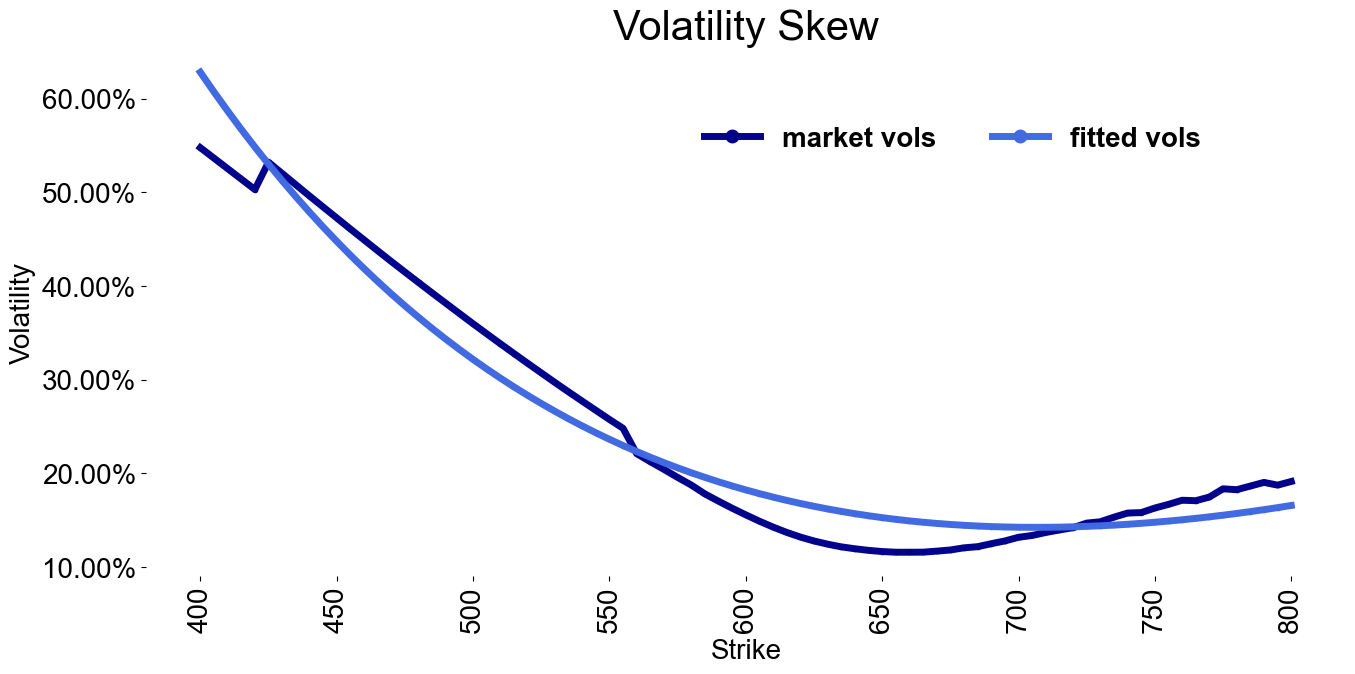

In [14]:
S0 = 590
sigma0 = optimal_parameters.x[0]
sigma1 = optimal_parameters.x[1]
sigma2 = optimal_parameters.x[2]

sigma_vector = []

for i in range (0, len(my_options_filtered_vols)):
    sigma = sigma0 + sigma1*np.log(my_options_filtered_strikes[i]/S0)+sigma2*(np.log(my_options_filtered_strikes[i]/S0))**2
    sigma_vector.append(sigma)


#Chart
font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=20)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(my_options_filtered_strikes,np.dot(my_options_filtered_vols,100),marker='o', linestyle='solid',linewidth = 5,color='darkblue',alpha = 0.99,label='market vols',markersize=3)
ax.plot(my_options_filtered_strikes,np.dot(sigma_vector,100),marker='o', linestyle='solid',linewidth = 5,color='royalblue',alpha = 0.99,label='fitted vols',markersize=3)
ax.legend(frameon=False,prop=font,loc=1, bbox_to_anchor=(0.9, 0.9),ncol=5,markerscale=3)
plt.xticks(rotation=90)
plt.yticks(fontname = "Arial",fontsize=20)
plt.xticks(fontname = "Arial",fontsize=20)
ax.set_title("Volatility Skew",fontsize=30)
ax.title.set_fontfamily('arial')
ax.yaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
ax.set_ylabel('Volatility',fontname = "Arial", fontsize=20,color='black')
ax.set_xlabel('Strike',fontname = "Arial", fontsize=20,color='black')
plt.subplots_adjust(bottom=0.1, right=2.0, top=1.2)

plt.box(on=None)

plt.show()

## **Calculate the implied density function from option prices**

<font size="3"> Now that we have the optimal parameters for our parabolic skew, we can calculate the implied density using the function we define at the beginning of this post as follows:<br><br>

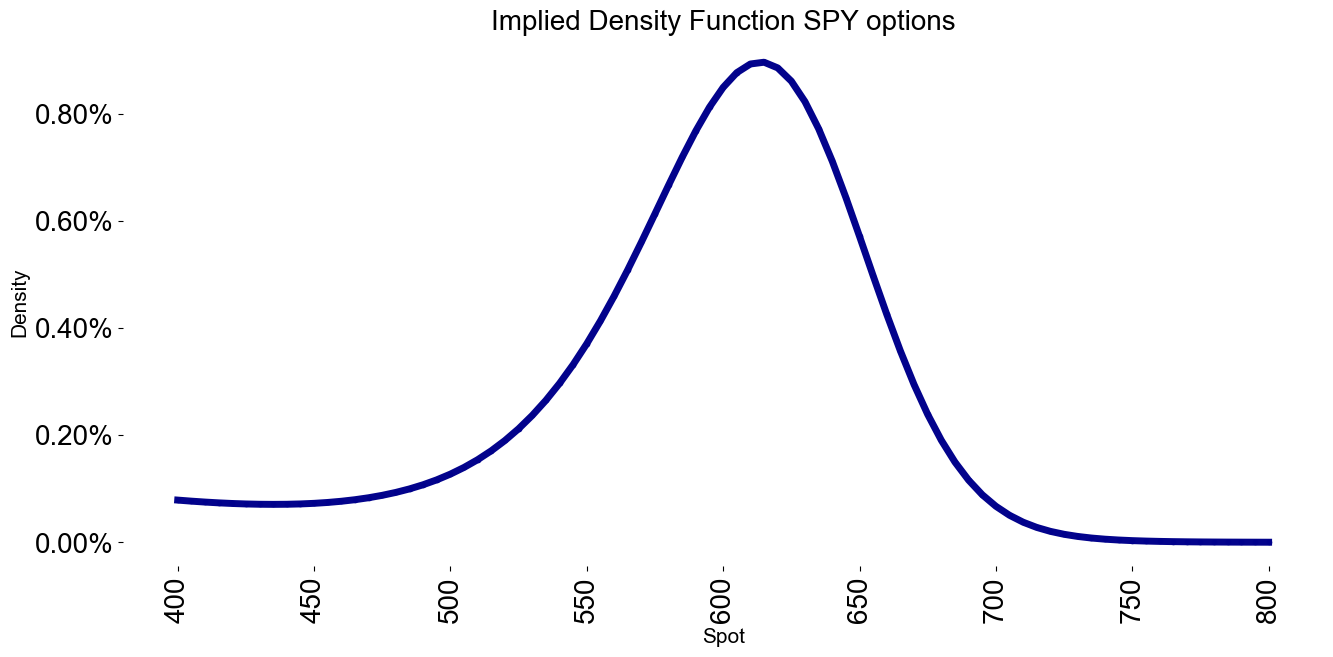

In [15]:
x = np.array(my_options_filtered_strikes)
  

RN_prob = bsparabolicprob( 590, x, 0.04, 0.25, optimal_parameters.x[0], optimal_parameters.x[1], optimal_parameters.x[2], q=0., t=0.) #15/01/2025

font = font_manager.FontProperties(family='arial',weight='bold', style='normal', size=20)

#Gráfico
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x,RN_prob*100,marker='o', linestyle='solid',linewidth = 5,color='darkblue',alpha = 0.99,label='SPY density function',markersize=3)
plt.xticks(rotation=90)
plt.yticks(fontname = "Arial",fontsize=20)
plt.xticks(fontname = "Arial",fontsize=20)
ax.set_title("Implied Density Function SPY options",fontsize=20)
ax.title.set_fontfamily('arial')
ax.yaxis.set_major_formatter(FormatStrFormatter('%2.2f%%'))
ax.set_ylabel('Density',fontname = "Arial", fontsize=15,color='black')
ax.set_xlabel('Spot',fontname = "Arial", fontsize=15,color='black')
plt.subplots_adjust(bottom=0.1, right=2.0, top=1.2)

plt.box(on=None)

plt.show()

<font size="3"> If this content is helpful and you want to make a donation please click on the button below. This helps us with the website maintenance. 

[![paypal](https://www.paypalobjects.com/en_US/i/btn/btn_donateCC_LG.gif)](https://www.paypal.com/cgi-bin/webscr?cmd=_s-xclick&hosted_button_id=29CVY97MEQ9BY)